In [5]:
! pip install geopandas
! pip install pulp
! pip install spopt
! pip install glpk
! pip install coinor-cbc
! pip install matplotlib-scalebar
! pip install seaborn

  Using cached glpk-0.4.7.tar.gz (161 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Failed to build glpk


  error: subprocess-exited-with-error
  
  × Building wheel for glpk (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [11 lines of output]
      WARNING setuptools_scm.pyproject_reading toml section missing 'pyproject.toml does not contain a tool.setuptools_scm section'
      Traceback (most recent call last):
        File "C:\Users\ASUS\AppData\Local\Temp\pip-build-env-jebijw9m\overlay\Lib\site-packages\setuptools_scm\_integration\pyproject_reading.py", line 36, in read_pyproject
          section = defn.get("tool", {})[tool_name]
                    ~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
      KeyError: 'setuptools_scm'
      running bdist_wheel
      running build
      running build_ext
      building 'glpk' extension
      error: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a p

In [6]:
%config InlineBackend.figure_format = "retina"
%load_ext watermark
%watermark

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2024-07-11T20:55:25.320729+07:00

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.24.0

Compiler    : MSC v.1938 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : Intel64 Family 6 Model 140 Stepping 1, GenuineIntel
CPU cores   : 8
Architecture: 64bit



In [7]:
import pandas as pd
import networkx as nx
import geopandas
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.lines as mlines
import matplotlib_scalebar
from matplotlib_scalebar.scalebar import ScaleBar
from shapely.geometry import Point
import time
import numpy as np
import pulp
import shapely
import spopt
from spopt.locate import PCenter, simulated_geo_points

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # ignore deprecation warning - GH pysal/spaghetti#649
    import spaghetti

%watermark -w
%watermark -iv

Watermark: 2.4.3

numpy              : 1.26.4
spopt              : 0.6.0
pandas             : 2.2.2
matplotlib_scalebar: 0.8.1
networkx           : 3.3
spaghetti          : 1.7.5.post1
shapely            : 2.0.4
matplotlib         : 3.9.0
geopandas          : 0.14.4
pulp               : 2.8.0



In [8]:
network_distance = pd.read_csv('C:/Users/ASUS/Downloads/project/python-rescue-station/scripts/test_demo/csv/network_distance.csv')
network_distance

,StartPoint,EndPoint,Distance
0,1,1,0
1,1,2,9
2,1,4,10
3,1,3,12
4,1,6,17
...,...,...,...
429,15,19,8
430,16,18,7
431,17,18,6
432,18,20,30


In [9]:
facility_points = pd.read_csv('C:/Users/ASUS/Downloads/project/python-rescue-station/scripts/test_demo/csv/facility_points.csv')
facility_points = facility_points.reset_index(drop=True)
facility_points

,Id,FacilityPoints,XX,YY
0,1,1,617714,1197576
1,2,2,617714,1196576
2,3,3,618714,1197076
3,4,4,619714,1197576
4,5,5,619714,1196576
5,6,6,620714,1197076
6,7,7,618714,1198076
7,8,8,619714,1198076
8,9,9,620714,1198076
9,10,10,619714,1198576


In [10]:
# Tạo bảng pivot từ dataframe
pivot_table = network_distance.pivot_table(values='Distance', index='EndPoint', columns='StartPoint')

# Thay thế các giá trị NaN = 0
cost_matrix = pivot_table.fillna(0).astype(int)

print(cost_matrix)

StartPoint  1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  \
EndPoint                                                                     
1            0   9  12  10  19  17  25  23  30  35  25  33  39  45  31  43   
2            9   0  13  19  17  26  34  32  39  44  34  42  48  54  40  52   
3           12  13   0   8   7  15  31  21  28  41  23  31  37  51  29  41   
4           10  19   8   0  13   7  23  13  20  33  15  23  29  43  21  33   
5           19  17   7  13   0   9  36  26  33  46  28  36  42  56  23  46   
6           17  26  15   7   9   0  30  20  27  40  21  29  35  50  14  39   
7           25  34  31  23  36  30   0  10  25  10  38  41  35  20  44  51   
8           23  32  21  13  26  20  10   0  33  20  28  36  42  30  34  46   
9           30  39  28  20  33  27  25  33   0  15  24  16  10  40  31  26   
10          35  44  41  33  46  40  10  20  15   0  39  31  25  25  46  41   
11          25  34  23  15  28  21  38  28  24  39   0   8  14  

In [11]:
# maximum service radius (in meters)
SERVICE_RADIUS = 18

# number of candidate facilities in optimal solution
# P_FACILITIES = 1

In [12]:
import pandas as pd
from spopt.locate import LSCP
import pulp

# Khởi tạo và giải quyết bài toán LSCP
lscp = LSCP.from_cost_matrix(cost_matrix, SERVICE_RADIUS)
lscp = lscp.solve(pulp.GLPK(msg=False))

# Lấy giá trị objective
lscp_objval = lscp.problem.objective.value()

# Tạo danh sách các điểm được chọn trong lscp_objval
selected_facilities = [i for i, dv in enumerate(lscp.fac_vars) if dv.varValue]

# Tạo DataFrame từ danh sách các điểm được chọn
selected_facilities_df = facility_points.iloc[selected_facilities].reset_index(drop=True)

# In giá trị objective và DataFrame các điểm được chọn
print("Objective value:", lscp_objval)
print("Các điểm được chọn làm facility:")
print(selected_facilities_df)

Objective value: 5
Các điểm được chọn làm facility:
   Id  FacilityPoints      XX       YY
0   3               3  618714  1197076
1   7               7  618714  1198076
2  12              12  621714  1198076
3  14              14  617714  1198576
4  15              15  622714  1197076


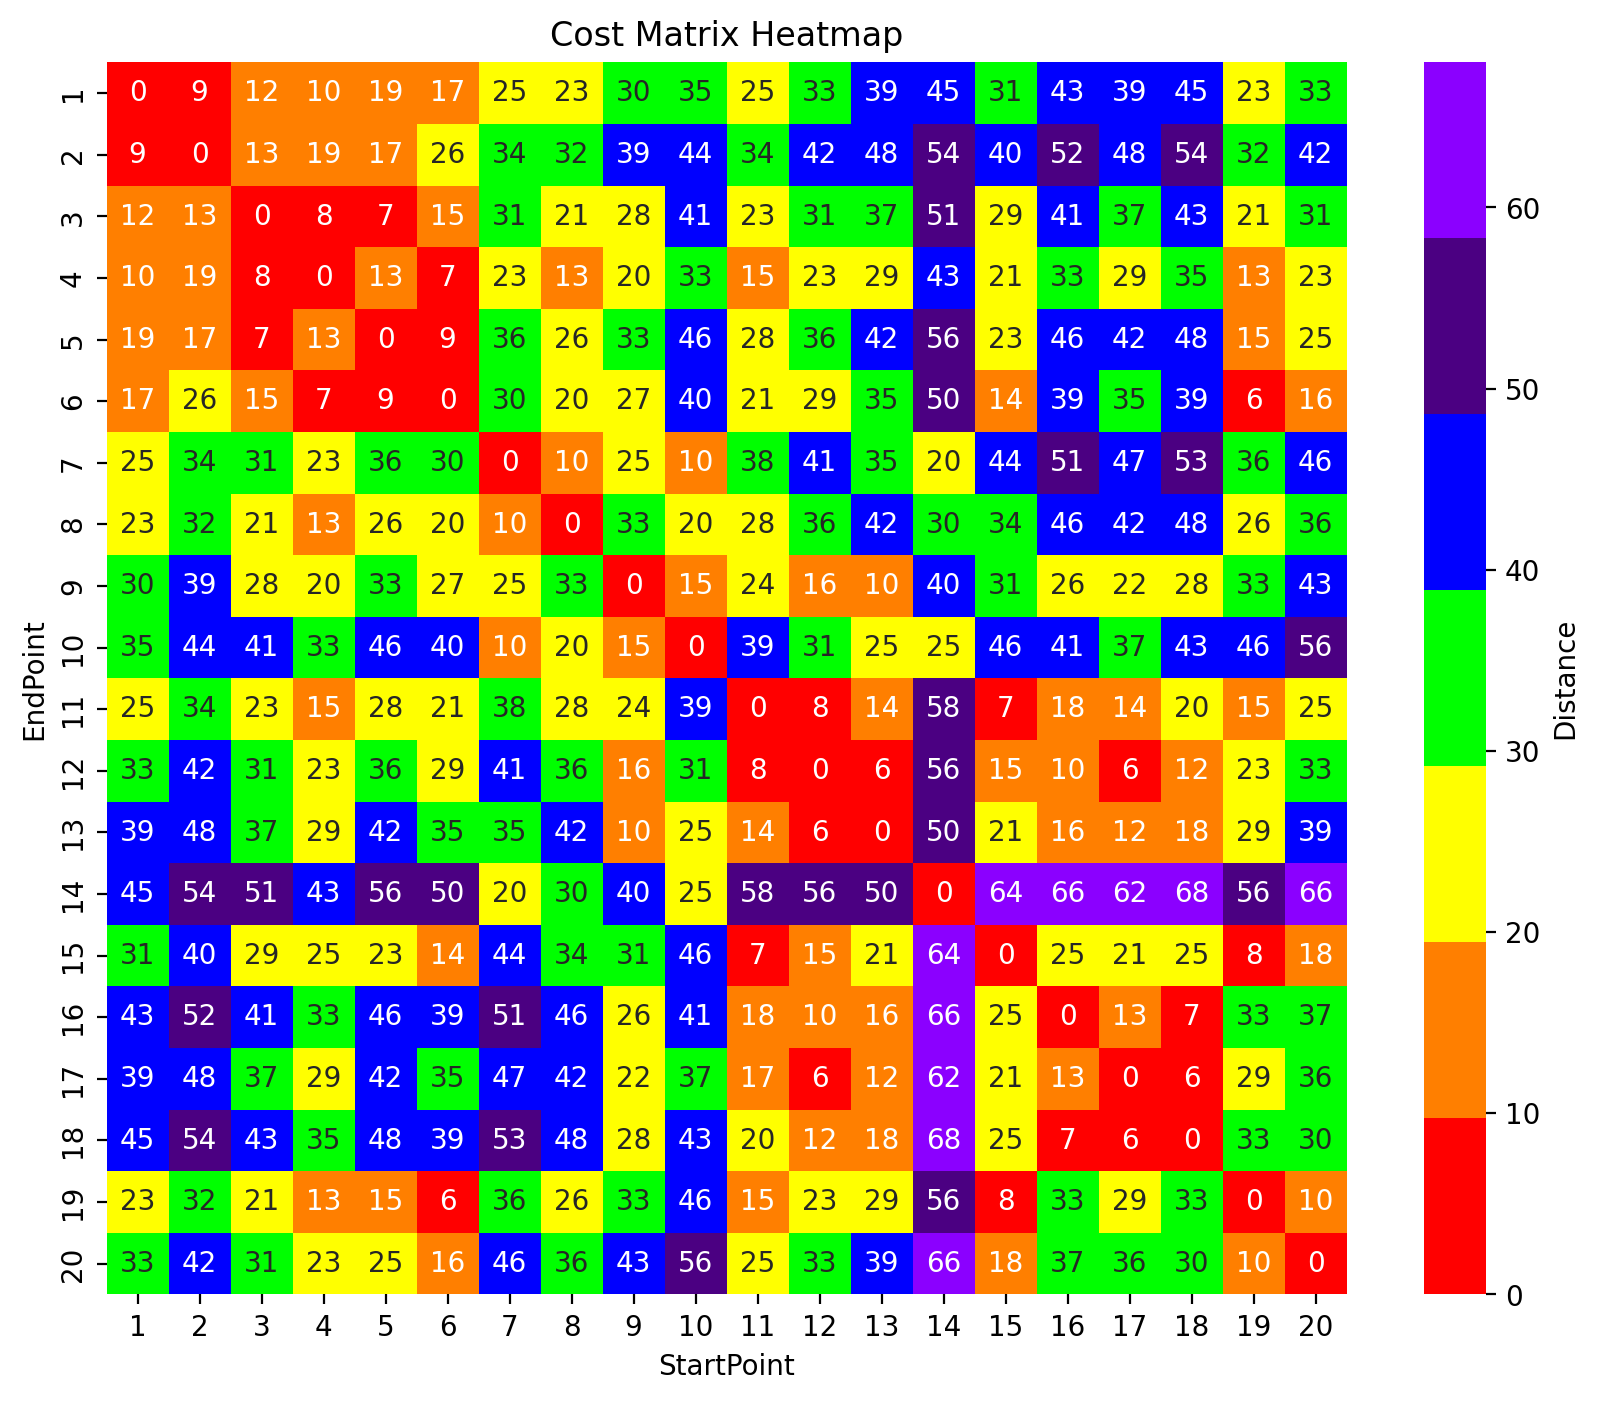

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

# Tạo bảng màu 7 sắc cầu vồng với độ sáng giảm đi
rainbow_colors = ["#FF0000", "#FF7F00", "#FFFF00", "#00FF00", "#0000FF", "#4B0082", "#8B00FF"]

# Điều chỉnh độ sáng của mỗi màu trong palette
lighter_colors = []
for color in rainbow_colors:
    rgb = mcolors.hex2color(color)  # Chuyển mã màu hex sang RGB
    lighter_rgb = tuple(c * 1.0 for c in rgb)  # Điều chỉnh độ sáng (0.7 làm màu nhạt hơn)
    lighter_hex = mcolors.rgb2hex(lighter_rgb)  # Chuyển lại sang mã màu hex
    lighter_colors.append(lighter_hex)

plt.figure(figsize=(10, 8))
sns.heatmap(cost_matrix, annot=True, fmt="d", cmap=sns.color_palette(lighter_colors), xticklabels='auto', yticklabels='auto', cbar_kws={'label': 'Distance'})
# Vẽ heatmap
# sns.heatmap(cost_matrix, annot=True, fmt="d", cmap=sns.color_palette("rainbow", as_cmap=True), cbar_kws={'label': 'Distance'},
#             square=False, linewidths=0.5, linecolor='white')
plt.title('Cost Matrix Heatmap')
plt.xlabel('StartPoint')
plt.ylabel('EndPoint')

plt.show()

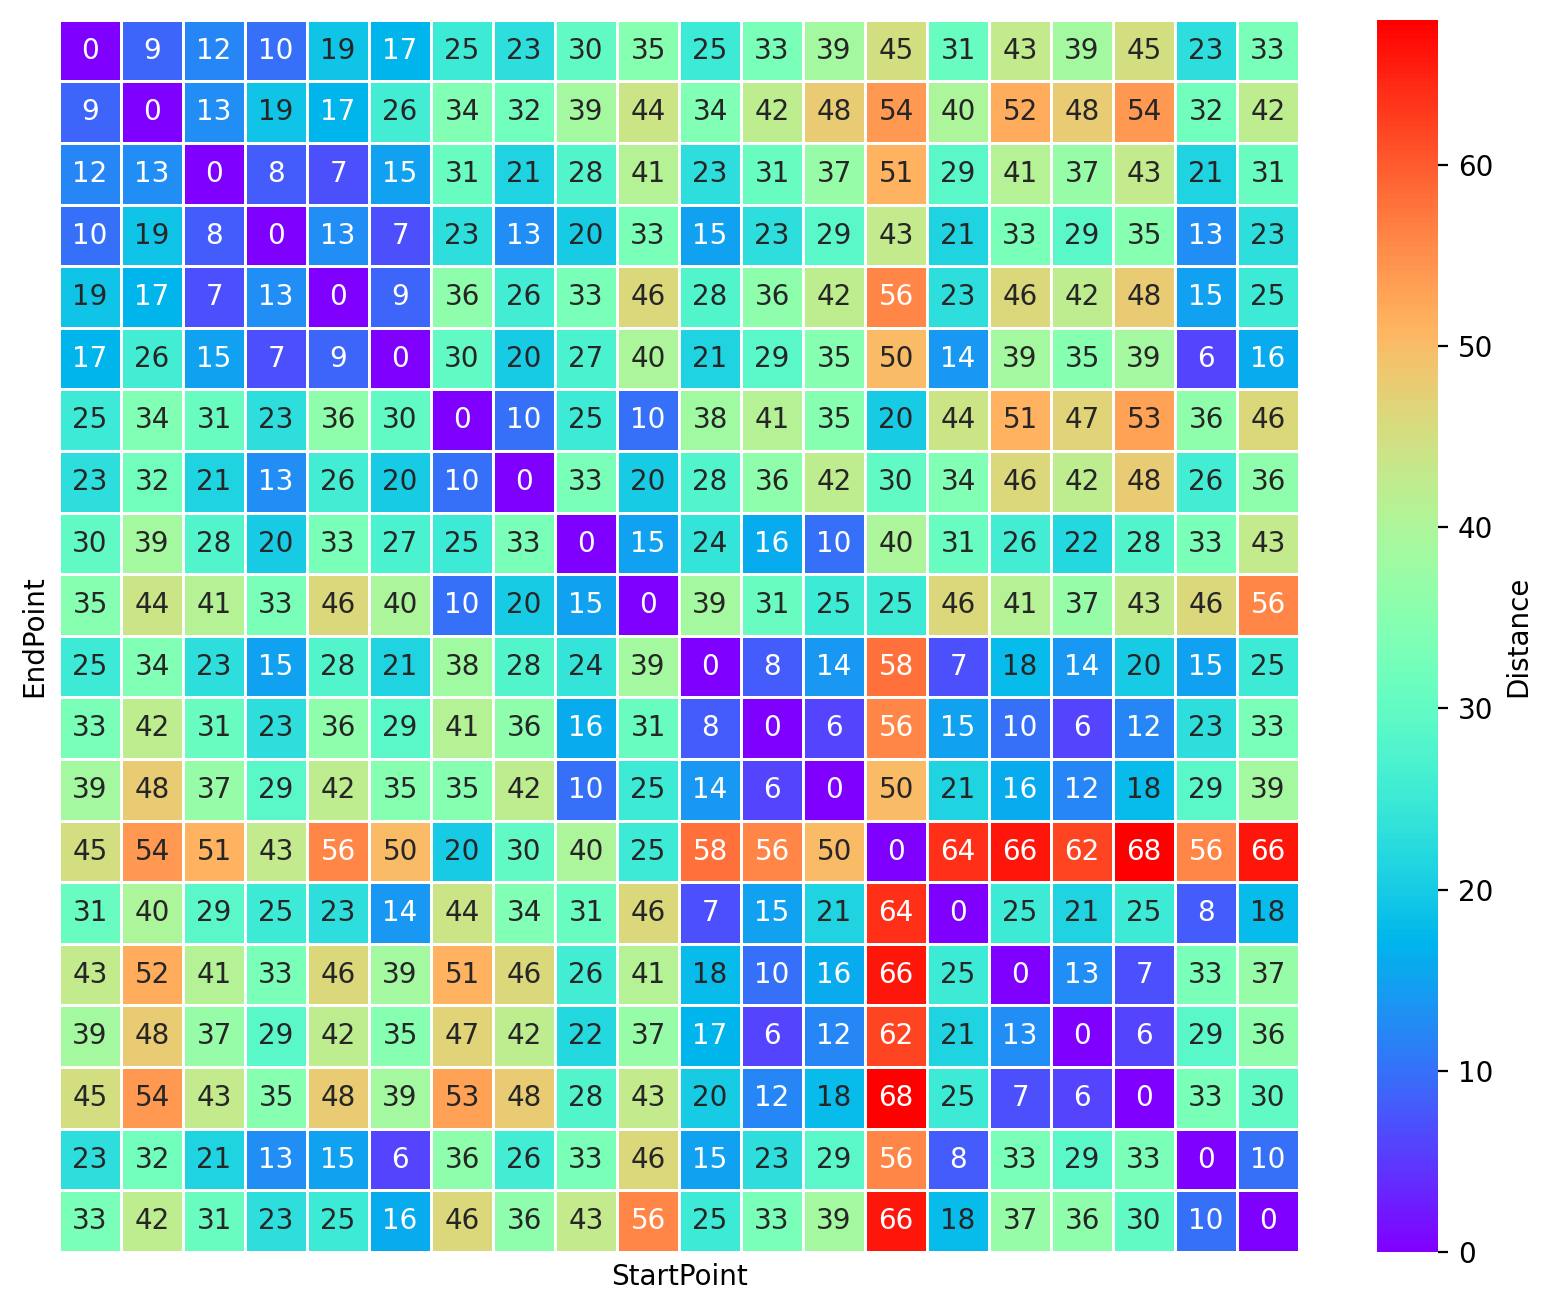

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Tạo bảng pivot từ dataframe
pivot_table = network_distance.pivot_table(values='Distance', index='EndPoint', columns='StartPoint')

# Thay thế các giá trị NaN = 0
cost_matrix = pivot_table.fillna(0).astype(int)

plt.figure(figsize=(10, 8))

# Vẽ heatmap
sns.heatmap(cost_matrix, annot=True, fmt="d", cmap=sns.color_palette("rainbow", as_cmap=True), cbar_kws={'label': 'Distance'},
            square=False, linewidths=0.5, linecolor='white')

# Ẩn các axis và chỉ mục mặc định
plt.xticks([])
plt.yticks([])

plt.show()


In [15]:
# Đổi tên cột index thành 'FacilityPoints' và reset index
cost_matrix.index.name = 'FacilityPoints'
cost_matrix.reset_index(inplace=True)

# Hiển thị kết quả mà không cần tên cột 'StartPoint'
print(cost_matrix.to_string(index=False))

 FacilityPoints  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20
              1  0  9 12 10 19 17 25 23 30  35  25  33  39  45  31  43  39  45  23  33
              2  9  0 13 19 17 26 34 32 39  44  34  42  48  54  40  52  48  54  32  42
              3 12 13  0  8  7 15 31 21 28  41  23  31  37  51  29  41  37  43  21  31
              4 10 19  8  0 13  7 23 13 20  33  15  23  29  43  21  33  29  35  13  23
              5 19 17  7 13  0  9 36 26 33  46  28  36  42  56  23  46  42  48  15  25
              6 17 26 15  7  9  0 30 20 27  40  21  29  35  50  14  39  35  39   6  16
              7 25 34 31 23 36 30  0 10 25  10  38  41  35  20  44  51  47  53  36  46
              8 23 32 21 13 26 20 10  0 33  20  28  36  42  30  34  46  42  48  26  36
              9 30 39 28 20 33 27 25 33  0  15  24  16  10  40  31  26  22  28  33  43
             10 35 44 41 33 46 40 10 20 15   0  39  31  25  25  46  41  37  43  46  56
             11 25 34 23 15 28 21 38 28 24 

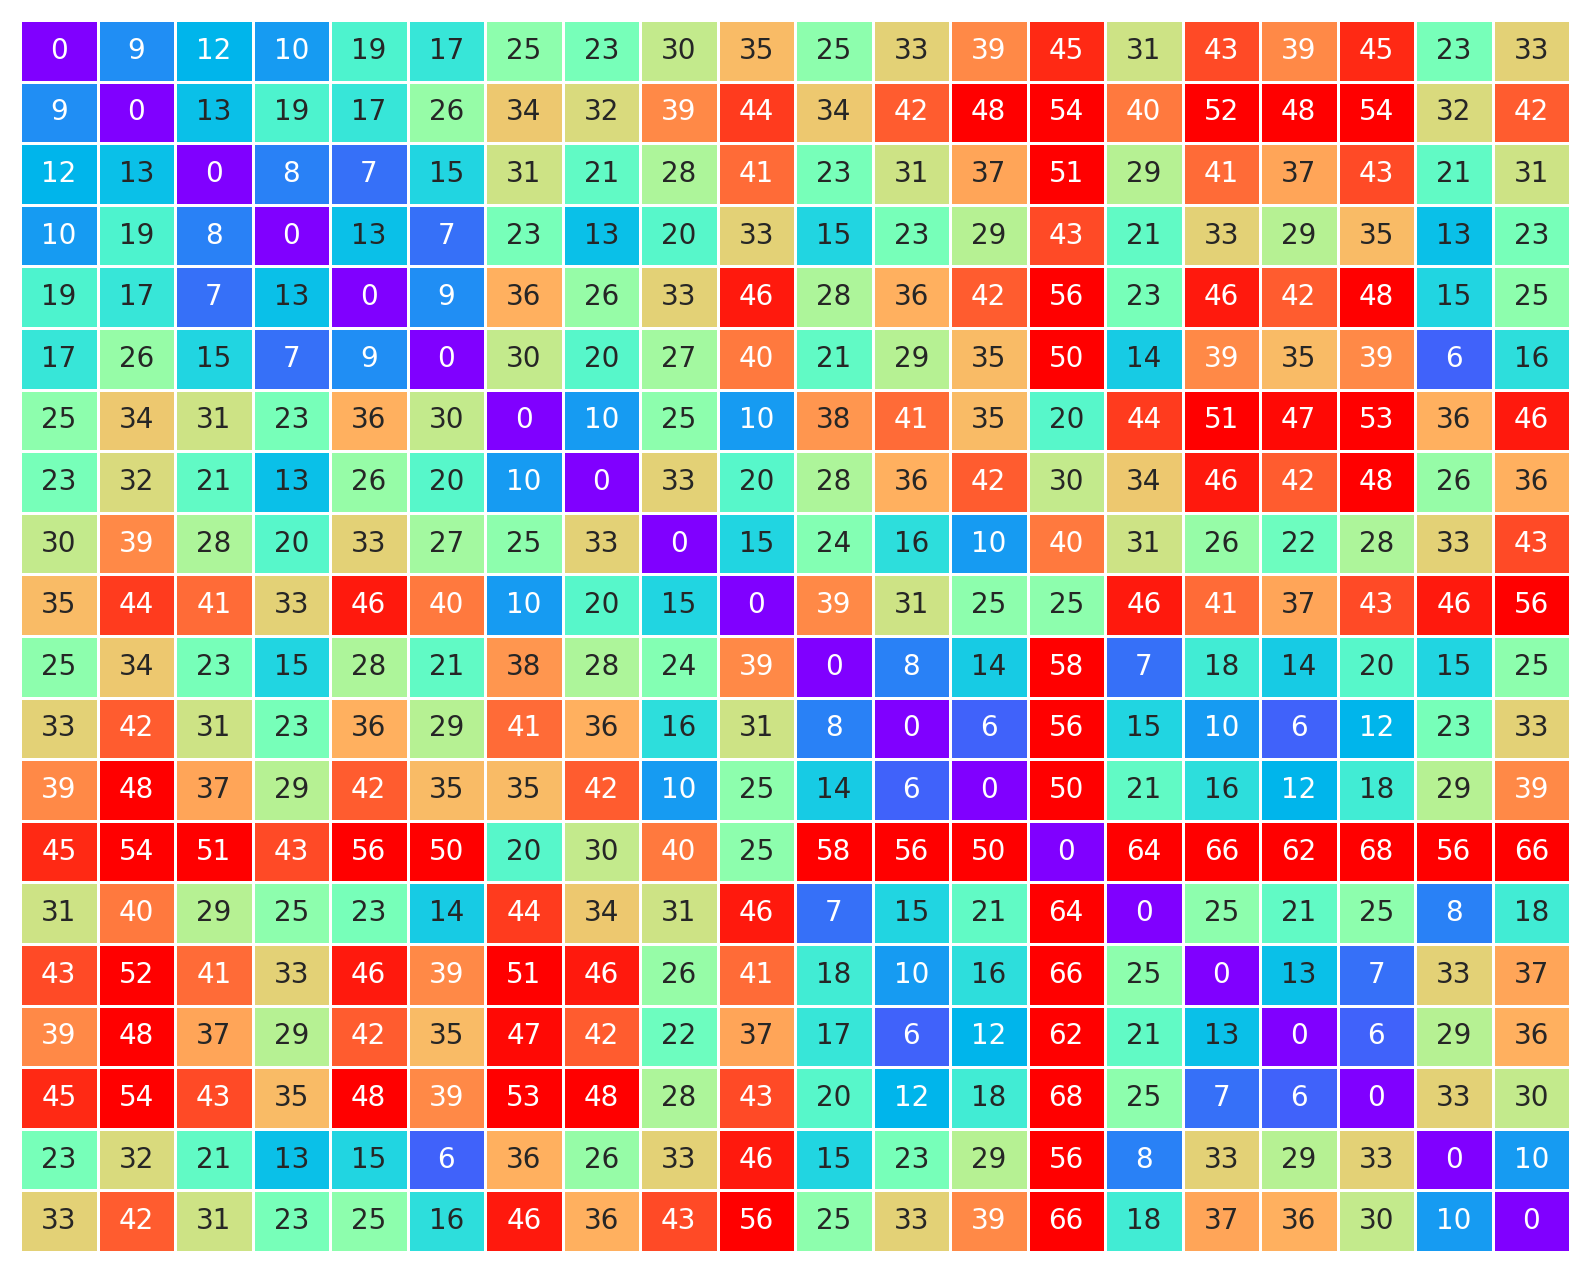

In [16]:
plt.figure(figsize=(10, 8))

# Tạo bảng pivot từ dataframe
pivot_table = network_distance.pivot_table(values='Distance', index='EndPoint', columns='StartPoint')

# Thay thế các giá trị NaN = 0
cost_matrix = pivot_table.fillna(0).astype(int)

# Vẽ heatmap với điều chỉnh màu sắc
sns.heatmap(cost_matrix, annot=True, fmt="d", cmap="rainbow",
            square=False, linewidths=0.5, linecolor='white', cbar=False, xticklabels=False, yticklabels=False,
            vmin=cost_matrix.min().min(), vmax=cost_matrix.max().max() * 0.7)  # Tăng độ đậm lên 20%

# Ẩn các axis và chỉ mục mặc định
plt.axis('off')

plt.show()
